In [1]:
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

In [2]:
import cv2

import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import supervision as sv  

# Load a SAM model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = "vit_b"  # Options: 'vit_h', 'vit_l', 'vit_b'

# ⚠️ Update this path to where you've downloaded the .pth file
checkpoint_path = "/Users/spartan/segment-anything/models/sam_vit_b_01ec64.pth"

# Load the model
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


Video contains 50004 frames.
Saved frame 50 to: /Users/spartan/Desktop/CV Project/frames/frame_50.jpg


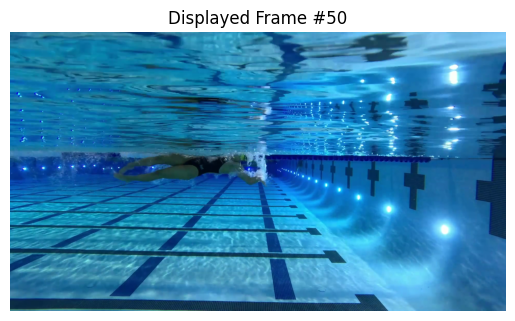

In [11]:
import cv2
import os
import matplotlib.pyplot as plt

# This will hold the number of the frame being used for segmentation
chosen_frame_index = 0  

def extract_specific_frame(video_file, output_dir, frame_to_extract=50):
    """
    Extracts a single frame from a given video file and saves it as an image.
    
    Parameters:
        video_file (str): Full path to the input video.
        output_dir (str): Directory where the extracted frame will be saved.
        frame_to_extract (int): Frame number to be captured from the video.
    
    Returns:
        image (ndarray): The extracted frame image.
    """
    global chosen_frame_index
    frame_counter = 0

    cap = cv2.VideoCapture(video_file)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video contains {total} frames.")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_counter == frame_to_extract:
            chosen_frame_index = frame_counter
            os.makedirs(output_dir, exist_ok=True)

            filename = os.path.join(output_dir, f"frame_{frame_counter}.jpg")
            cv2.imwrite(filename, frame)
            print(f"Saved frame {frame_counter} to: {filename}")
            cap.release()
            return frame

        frame_counter += 1

    cap.release()
    print(f"Frame {frame_to_extract} could not be extracted.")
    return None

# ==== CONFIGURATION ====
video_path = "/Users/spartan/Desktop/CV Project/All_Strokes.mp4"
output_path = "/Users/spartan/Desktop/CV Project/frames"
target_frame = 50

# ==== RUNNING THE FUNCTION ====
frame_image = extract_specific_frame(video_path, output_path, frame_to_extract=target_frame)

# ==== DISPLAYING THE FRAME ====
if frame_image is not None:
    plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Displayed Frame #{chosen_frame_index}")
    plt.axis("off")
    plt.show()

    # Convert to RGB for segmentation use
    frame_rgb = cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB)


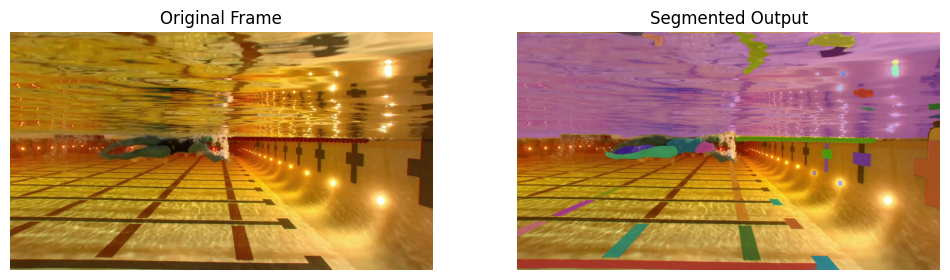

Annotated frame saved to: /Users/spartan/Desktop/CV Project/annotated_frame.jpg


In [12]:
# Initialize an automatic mask generator using the pre-loaded SAM model
mask_generator = SamAutomaticMaskGenerator(sam)

# Use the generator to predict segmentation masks for the given image (in RGB format)
sam_result = mask_generator.generate(frame_rgb)

# Initialize the annotator with distinct colors for each segmentation mask
segment_visualizer = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM's output into a format compatible with Supervision for visualization
segmentation_data = sv.Detections.from_sam(sam_result=sam_result)

# Create a copy of the image and overlay the masks on it
image_with_masks = segment_visualizer.annotate(
    scene=frame_rgb.copy(), 
    detections=segmentation_data
)

# Display original and masked images side by side
sv.plot_images_grid(
    images=[frame_rgb, image_with_masks],
    grid_size=(1, 2),
    titles=['Original Frame', 'Segmented Output']
)

# Save the annotated frame locally (update this path as needed)
output_path = "/Users/spartan/Desktop/CV Project/annotated_frame.jpg"
cv2.imwrite(output_path, image_with_masks)
print(f"Annotated frame saved to: {output_path}")

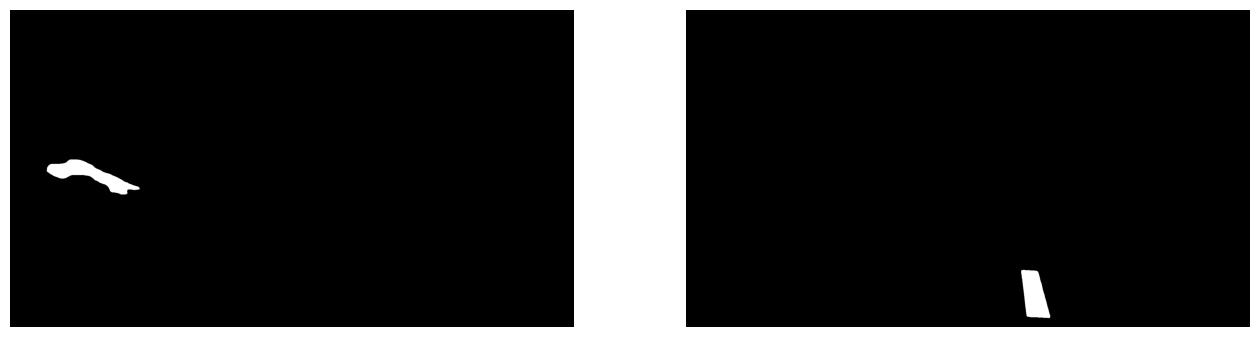

In [5]:
import math

# Select and sort masks based on area (largest first)
top_masks = sorted(sam_result, key=lambda item: item['area'], reverse=True)
binary_masks = [entry['segmentation'] for entry in top_masks]

# Optionally limit to a specific range of masks for display (e.g., 4th and 5th largest)
sampled_masks = binary_masks[3:5]

# Display the selected subset of masks in a horizontal layout
sv.plot_images_grid(
    images=sampled_masks,
    grid_size=(1, len(sampled_masks)),  # 1 row, N columns based on sample size
    size=(16, 16)
)


In [6]:
# # Create an empty mask with the same shape as one of the selected masks
# merged_mask = np.zeros_like(top_masks[0], dtype=bool)

# # Combine multiple binary masks into a single mask using logical OR
# for single_mask in top_masks:
#     merged_mask = np.logical_or(merged_mask, single_mask)

# # Convert the merged boolean mask to an 8-bit image for display or processing
# final_mask = merged_mask.astype(np.uint8)


import numpy as np

# Step 1: Extract binary masks from the SAM result entries
binary_masks = [entry['segmentation'] for entry in top_masks]

# Step 2: Create an empty mask of the same shape as the first one
merged_mask = np.zeros_like(binary_masks[0], dtype=bool)

# Step 3: Combine all masks using logical OR to accumulate all active areas
for mask in binary_masks:
    merged_mask = np.logical_or(merged_mask, mask)

# Step 4: Convert the final mask to 8-bit format for visualization or saving
final_mask = merged_mask.astype(np.uint8)


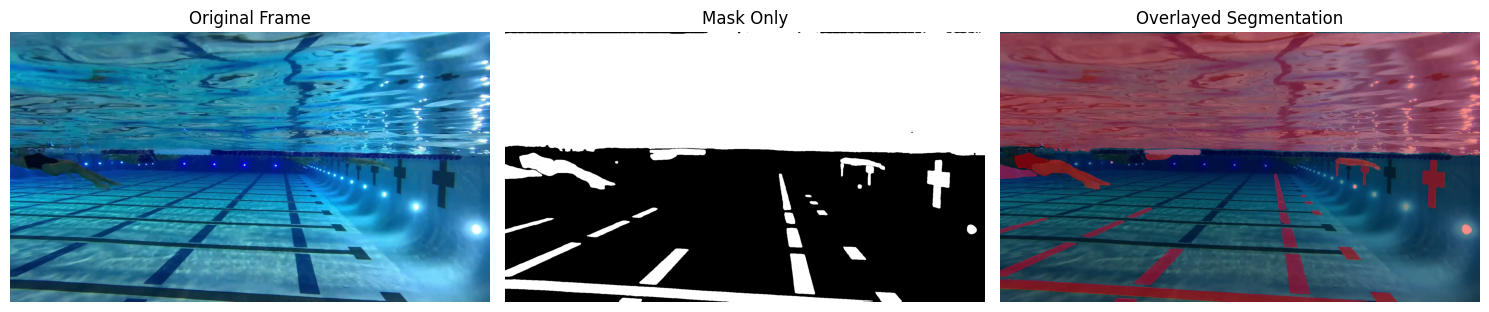

In [7]:
# Convert the logical mask to 8-bit format (values 0 or 1)
mask_uint8 = merged_mask.astype(np.uint8)

# Set transparency for overlaying the segmentation
opacity = 0.45  # Adjust this between 0 (invisible) and 1 (solid)

# Choose an RGB color to highlight the masked area (e.g., red)
overlay_color = [0, 0, 255]

# Create a blank image with the same shape as the input and apply the color where mask is active
highlight = np.zeros_like(frame_image)
highlight[mask_uint8 == 1] = overlay_color

# Blend the original image with the colored mask using weighted addition
output_with_mask = cv2.addWeighted(highlight, opacity, frame_image, 1 - opacity, 0)

# === Displaying Results ===
plt.figure(figsize=(15, 5))

# Display original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis("off")

# Display the binary mask
plt.subplot(1, 3, 2)
plt.imshow(mask_uint8, cmap="gray")
plt.title("Mask Only")
plt.axis("off")

# Display the image with the mask overlay
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_with_mask, cv2.COLOR_BGR2RGB))
plt.title("Overlayed Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
import base64
from jupyter_bbox_widget import BBoxWidget
from IPython.display import display

def load_image_as_base64(image_path):
    """
    Loads an image from disk and returns a base64-encoded string for display in widgets.
    """
    with open(image_path, "rb") as img_file:
        encoded_bytes = base64.b64encode(img_file.read()).decode("utf-8")
    return f"data:image/jpeg;base64,{encoded_bytes}"

# Replace this with the actual frame you want to annotate
frame_index = chosen_frame_index  # You may set this to a specific number like 50

# Construct the full path to the image you want to annotate
frame_path = f"/Users/spartan/Desktop/CV Project/frames/frame_{frame_index}.jpg"

# Create and configure the widget
bbox_tool = BBoxWidget()
bbox_tool.image = load_image_as_base64(frame_path)

# Show the widget
display(bbox_tool)

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

Number of boxes: 0
Boxes: []


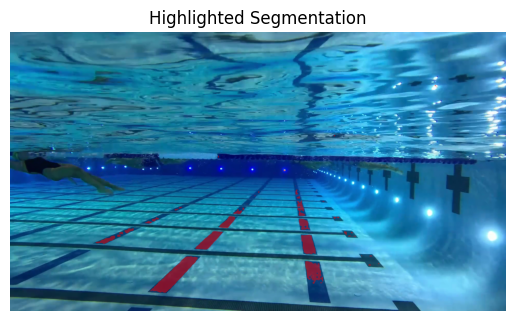

Saved segmented output to: /Users/spartan/Desktop/CV Project/Output/frame96.jpg


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Display the number of drawn boxes and the actual box data
print("Number of boxes:", len(bbox_tool.bboxes))
print("Boxes:", bbox_tool.bboxes)

# Use the drawn box if available; otherwise, fall back to a default region
fallback_box = {'x': 205, 'y': 182, 'width': 1496, 'height': 792, 'label': ''}
box_data = bbox_tool.bboxes[0] if bbox_tool.bboxes else fallback_box

# Format the box as [x1, y1, x2, y2] for the SAM predictor
box_coords = np.array([
    box_data['x'],
    box_data['y'],
    box_data['x'] + box_data['width'],
    box_data['y'] + box_data['height']
])

# Initialize SAM predictor and load the frame for mask prediction
predictor = SamPredictor(sam)
predictor.set_image(frame_rgb)

# Run segmentation with the selected or default bounding box
predicted_masks, mask_scores, _ = predictor.predict(
    box=box_coords,
    multimask_output=False
)

# Initialize annotation tools with consistent coloring
box_drawer = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_drawer = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# Prepare the prediction result for visualization
segment_data = sv.Detections(
    xyxy=sv.mask_to_xyxy(predicted_masks),
    mask=predicted_masks
)

# Keep only the mask with the largest area (most relevant detection)
segment_data = segment_data[segment_data.area == np.max(segment_data.area)]

# Draw bounding box and mask overlay on separate copies of the image
image_with_box = box_drawer.annotate(scene=frame_image.copy(), detections=segment_data)
image_with_mask = mask_drawer.annotate(scene=frame_image.copy(), detections=segment_data)

# Show the mask output
plt.imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
plt.title("Highlighted Segmentation")
plt.axis("off")
plt.show()

# Save the final annotated image to disk
output_path = f"/Users/spartan/Desktop/CV Project/Output/frame{chosen_frame_index}.jpg"
cv2.imwrite(output_path, image_with_mask)
print(f"Saved segmented output to: {output_path}")


Total frames in video: 50004
Saved frame #50 at /Users/spartan/Desktop/CV Project/frames/frame_50.jpg


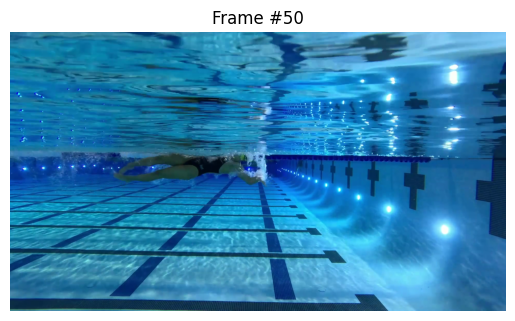

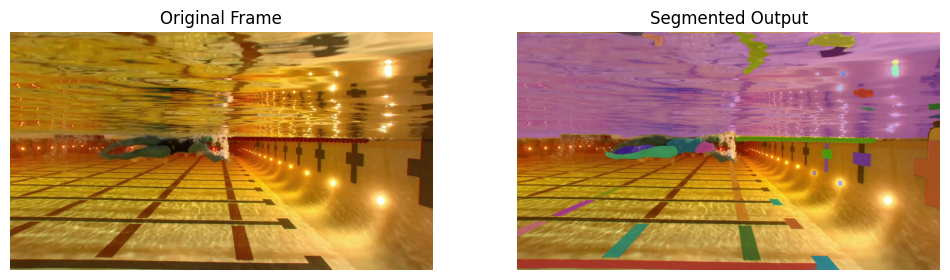

Saved segmented image at: /Users/spartan/Desktop/CV Project/annotated_frame.jpg


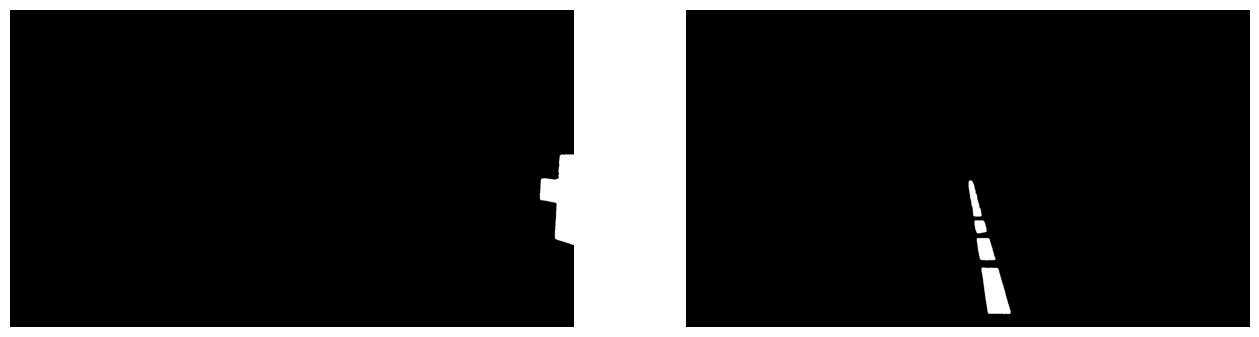

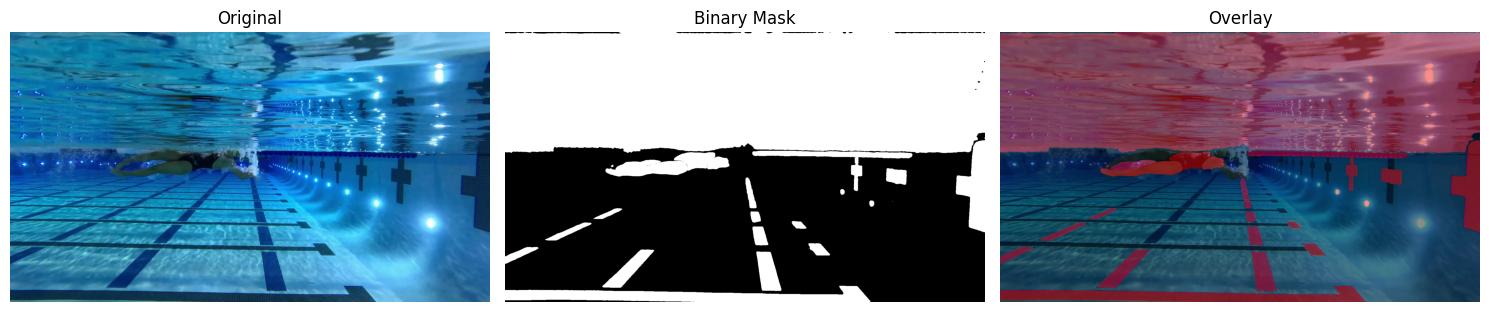

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

Number of boxes: 0
Boxes: []


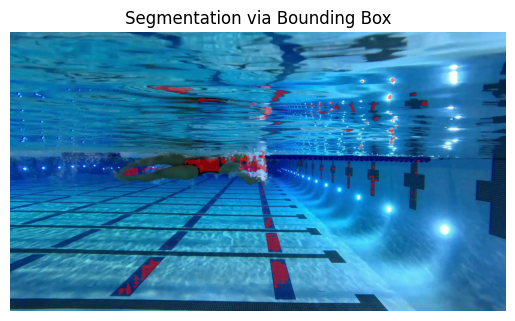

Final segmented output saved to: /Users/spartan/Desktop/CV Project/Output/frame50.jpg


In [10]:
# === Import Libraries ===
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv
from jupyter_bbox_widget import BBoxWidget
from IPython.display import display
import base64

# === Load SAM Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = "vit_b"
checkpoint_path = "/Users/spartan/segment-anything/models/sam_vit_b_01ec64.pth"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device)

# === Function: Extract Frame from Video ===
def extract_frame(video_path, save_dir, frame_index):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    frame_number = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_number == frame_index:
            os.makedirs(save_dir, exist_ok=True)
            output_file = os.path.join(save_dir, f"frame_{frame_index}.jpg")
            cv2.imwrite(output_file, frame)
            print(f"Saved frame #{frame_index} at {output_file}")
            cap.release()
            return frame
        frame_number += 1

    cap.release()
    print(f"Failed to extract frame #{frame_index}")
    return None

# === Parameters ===
video_path = "/Users/spartan/Desktop/CV Project/All_Strokes.mp4"
frame_save_path = "/Users/spartan/Desktop/CV Project/frames"
frame_index = 50

# === Frame Extraction and Display ===
frame_bgr = extract_frame(video_path, frame_save_path, frame_index)
if frame_bgr is None:
    raise ValueError("No frame extracted.")

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.title(f"Frame #{frame_index}")
plt.axis("off")
plt.show()

# === Automatic Mask Generation ===
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(frame_rgb)

annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=masks)
masked_image = annotator.annotate(scene=frame_rgb.copy(), detections=detections)

# Display original vs segmented
sv.plot_images_grid([frame_rgb, masked_image], (1, 2), titles=["Original Frame", "Segmented Output"])

# Save output
output_masked_path = "/Users/spartan/Desktop/CV Project/annotated_frame.jpg"
cv2.imwrite(output_masked_path, masked_image)
print(f"Saved segmented image at: {output_masked_path}")

# === Extract and Merge Masks ===
sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
binary_masks = [m['segmentation'] for m in sorted_masks]
subset_masks = binary_masks[3:5]  # e.g., 4th & 5th largest

sv.plot_images_grid(subset_masks, (1, len(subset_masks)), size=(16, 16))

# Merge all masks
merged = np.zeros_like(binary_masks[0], dtype=bool)
for m in binary_masks:
    merged = np.logical_or(merged, m)
merged_uint8 = merged.astype(np.uint8)

# Overlay merged mask
highlight = np.zeros_like(frame_bgr)
highlight[merged_uint8 == 1] = [0, 0, 255]  # Red color
overlayed = cv2.addWeighted(highlight, 0.45, frame_bgr, 0.55, 0)

# Show results
plt.figure(figsize=(15, 5))
titles = ["Original", "Binary Mask", "Overlay"]
images = [frame_bgr, merged_uint8, overlayed]
for i, img in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if i != 1 else img, cmap='gray' if i == 1 else None)
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

# === Bounding Box Widget Annotation ===
def encode_image_base64(image_path):
    with open(image_path, "rb") as img_file:
        return f"data:image/jpeg;base64,{base64.b64encode(img_file.read()).decode('utf-8')}"

frame_path = f"/Users/spartan/Desktop/CV Project/frames/frame_{frame_index}.jpg"
bbox_widget = BBoxWidget()
bbox_widget.image = encode_image_base64(frame_path)
display(bbox_widget)

# === Use Bounding Box with SAM Predictor ===
print("Number of boxes:", len(bbox_widget.bboxes))
print("Boxes:", bbox_widget.bboxes)

fallback = {'x': 205, 'y': 182, 'width': 1496, 'height': 792}
box = bbox_widget.bboxes[0] if bbox_widget.bboxes else fallback
box_coords = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

predictor = SamPredictor(sam)
predictor.set_image(frame_rgb)
pred_masks, scores, _ = predictor.predict(box=box_coords, multimask_output=False)

# Visualize single best detection
det = sv.Detections(xyxy=sv.mask_to_xyxy(pred_masks), mask=pred_masks)
det = det[det.area == np.max(det.area)]

# Draw results
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

box_image = box_annotator.annotate(frame_bgr.copy(), detections=det)
mask_image = mask_annotator.annotate(frame_bgr.copy(), detections=det)

plt.imshow(cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB))
plt.title("Segmentation via Bounding Box")
plt.axis("off")
plt.show()

# Save final result
final_output_path = f"/Users/spartan/Desktop/CV Project/Output/frame{frame_index}.jpg"
cv2.imwrite(final_output_path, mask_image)
print(f"Final segmented output saved to: {final_output_path}")
